# Traffic Sign Classification with Tensorflow


## Step 0: Load Image Dataset

In [7]:
import numpy as np
import pickle
import os
from tqdm import tqdm
from zipfile import ZipFile

# Define variables
setnames = []
data     = dict()
X        = dict()
y        = dict()

path = "/home/tiwi/Documents/mldata/"
file = "traffic-signs-data.zip"


print("Filenames in data container: \n")
for filename in ZipFile(path+file).namelist():
    print(filename)
    # Create setnames from filenames: e.g. "train", "test", ...
    setnames.append(os.path.split(filename)[1].rpartition('.')[0])
    # Get full path + file for each pickle file
    with open(path + file.rpartition('.')[0] + '/' + filename, mode='rb') as f:
        data[setnames[-1]] = pickle.load(f)
        
for setname in setnames:
    X[setname], y[setname] = data[setname]['features'], data[setname]['labels']
        

Filenames in data container: 

test.p
train.p
valid.p



## Step 1: Print Dataset Information

In [39]:
classes = pd.read_csv("../CarND-Traffic-Sign-Classifier-Project/signnames.csv")
nb_classes = len(set(y["train"]))

print("Number of training examples:\t", X["train"].shape[0])
print("Number of testing examples:\t",  X["test"].shape[0])
print("Image data shape:\t\t",          X["train"].shape[1:])
print("Number of classes:\t\t",         nb_classes)

print(classes)

Number of training examples:	 34799
Number of testing examples:	 12630
Image data shape:		 (32, 32, 3)
Number of classes:		 43
    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Prior

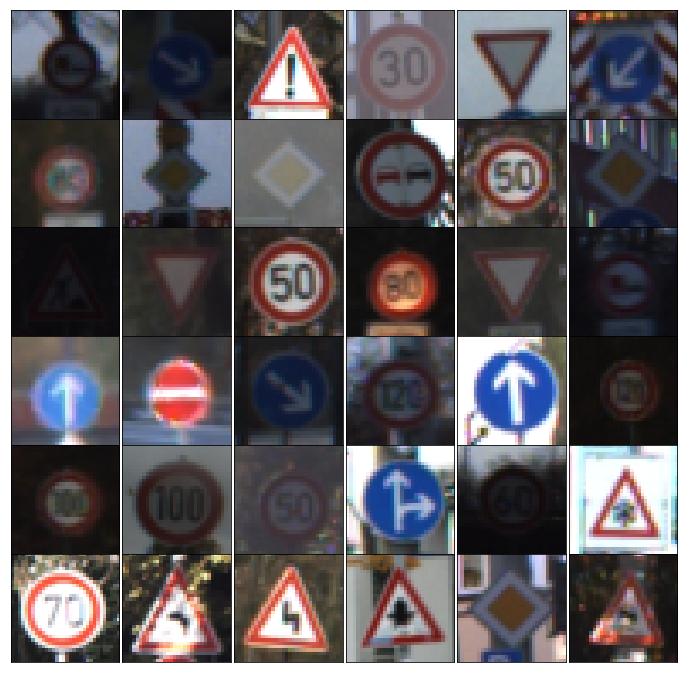

In [83]:
'''
Show all different interpolation methods for imshow
'''

import matplotlib.pyplot as plt
# Define square number of example images
n = np.int(np.floor(np.sqrt(nb_classes)))
nb_plots = n**2
random_images = [X["train"][i,::] for i in np.random.randint(0, X["train"].shape[0], nb_plots)]

# Setup a grid [n x n] grid of subplots
fig, axes = plt.subplots(n, n, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for img, ax, img_class in zip(random_images, axes.flat, classes["SignName"][0:nb_plots]):
    ax.imshow(img)
    
plt.show()

